<img src='./img/logoline_12000.png' align='center' width='100%'></img>

<br>

# Analysing climate extremes


### About

This notebook provides you an introduction of analysing climate extremes. The case study focuses on climate extremes in the area surrounding the city of Lille in Northern France, which was affected by the heatwave in September 2020 that affected western Europe.
The first section [1 - Data preparation](#data_preparation) is mandatory, as it loads and prepares the dataset for the following parts.

of the maximum daily temperatures in September over the period from 1979 to 2019, and compare these with our findings for 2020.

The tutorial has the following outline:

* [1 - Data preparation](#read_data)
* [2 - Visualize daily maximum 2m air temperature](#t2m_max)
* [3 - Calculate averages](#calculate_averages)

### Data

This notebook introduces you to the ERA-5 reanalysis monthly averaged data on single levels. The data has the following specifications:

> **Data**: `ERA-5 monthly averaged data on single levels` <br>
> **Temporal coverage**: `Jan 1979 to Dec 2020` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5_monthly)

Get [here](./101_c3s_data_intro.ipynb) more information about climate reanalysis data in general including an overview of they different dataset types.

### Further resources

* [Heatwave shatters September records in western Europe](https://www.euronews.com/2020/09/16/heatwave-shatters-september-records-in-western-europe)

<hr>

### Load libraries

In [4]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# to suppress SSL warnings
import urllib3
urllib3.disable_warnings()

### Load helper functions

In [1]:
%run ./functions.ipynb

<hr>

## <a id='data_preparation'></a>1. Data preparation


The example below will show you how to ...

### Load the dataset

The first step is to open the dataset with the function `open_dataset()` of the Python library [xarray](http://xarray.pydata.org/en/stable/). xarray is a Python library that makes the handling of multi-dimensional meteorological and climate data as well as `netCDF` data very efficient. The data file is available under the path: `./data/era5_t2m_hourly_northern_france_sep.nc`. 

The `open_dataset()` function returns a `xarray.Dataset` object, which can hold one or more `xarray.DataArray` objects, which are aligned on the same dimensions. The loaded `xarray.Dataset` has the following specifications: 
* three dimensions: `latitude`, `longitude` and `time` and
* 1 data variable: `t2m`

In [2]:
file = './data/era5_t2m_hourly_northern_france_sep.nc'

In [5]:
era5_t2m_hourly_ds = xr.open_dataset(file)
era5_t2m_hourly_ds

<xarray.Dataset>
Dimensions:    (longitude: 5, latitude: 5, time: 30240)
Coordinates:
  * longitude  (longitude) float32 3.0 3.25 3.5 3.75 4.0
  * latitude   (latitude) float32 51.0 50.75 50.5 50.25 50.0
  * time       (time) datetime64[ns] 1979-09-01 ... 2020-09-30T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-21 13:29:28 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

<br>

The next step is to load the data variable `t2m` as `xarray.DataArray` object. You can load a data variable from an `xarray.Dataset` by specifying the name of the data variable (`t2m`) in square brackets `[]`. A `xarray.DataArray` object is a labeled, multi-dimensional array, which you can modify and apply operations on. Below, you see additional `attributes` of the data variable, such as `units` and `long_name`.

In [6]:
era5_t2m_hourly_da = era5_t2m_hourly_ds['t2m']
era5_t2m_hourly_da

<xarray.DataArray 't2m' (time: 30240, latitude: 5, longitude: 5)>
[756000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 3.0 3.25 3.5 3.75 4.0
  * latitude   (latitude) float32 51.0 50.75 50.5 50.25 50.0
  * time       (time) datetime64[ns] 1979-09-01 ... 2020-09-30T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

<br>

Above, you see that the ERA-5 temperature data are per default in `Kelvin`, the base unit for temperature in the International System of Units (SI). If you want to convert the values from `Kelvin` to `degrees Celsius`, the formula is simple: 
> `degrees Celsius = Kelvin - 273.15`

In [9]:
era5_t2m_hourly_degc = era5_t2m_hourly_da - 273.15
era5_t2m_hourly_degc

<xarray.DataArray 't2m' (time: 30240, latitude: 5, longitude: 5)>
array([[[16.688995 , 16.261627 , 15.913879 , 15.6362915, 16.374664 ],
        [16.933228 , 16.616974 , 16.654175 , 17.03482  , 16.490082 ],
        [16.943237 , 16.503448 , 16.269257 , 16.306458 , 15.826111 ],
        [16.769135 , 16.57022  , 16.292633 , 15.89624  , 16.222504 ],
        [16.808258 , 16.406158 , 16.026947 , 15.662048 , 15.763641 ]],

       [[16.670868 , 16.332703 , 15.914856 , 15.448364 , 16.282135 ],
        [16.713806 , 16.559265 , 16.069397 , 15.405426 , 15.153107 ],
        [16.668976 , 16.407104 , 15.989258 , 15.440247 , 15.360107 ],
        [16.453857 , 16.149536 , 15.754578 , 15.42688  , 15.069153 ],
        [16.793945 , 16.326965 , 15.786072 , 15.391602 , 15.034332 ]],

       [[16.289764 , 15.9496765, 15.613861 , 15.264221 , 15.74646  ],
        [16.172424 , 16.174316 , 15.70163  , 14.979004 , 14.723328 ],
        [16.295471 , 16.1958   , 15.735016 , 15.066772 , 14.8463745],
        [16.414734 , 16.236816 , 15.760315 , 15.035767 , 14.574982 ],
        [16.57071  , 16.201508 , 15.687805 , 15.018097 , 14.525848 ]],

       ...,

       [[16.292633 , 16.19101  , 16.13092  , 16.081787 , 16.042694 ],
        [16.216766 , 16.12091  , 15.985931 , 15.808472 , 15.650116 ],
        [15.999756 , 16.026947 , 15.810394 , 15.523224 , 15.310486 ],
        [15.722626 , 15.7283325, 15.50177  , 15.1111145, 14.745758 ],
        [15.535156 , 15.480316 , 15.285217 , 14.933197 , 14.52536  ]],

       [[16.189117 , 16.101349 , 16.046509 , 16.00357  , 15.939178 ],
        [16.163849 , 16.138092 , 16.026947 , 15.857117 , 15.673492 ],
        [15.90387  , 16.165741 , 16.038849 , 15.76889  , 15.49176  ],
        [15.739777 , 15.880493 , 15.747437 , 15.390167 , 14.942749 ],
        [15.653931 , 15.652039 , 15.434998 , 15.095367 , 14.610748 ]],

       [[15.845673 , 15.7951355, 15.900543 , 16.07608  , 16.043152 ],
        [15.793213 , 15.870972 , 15.91629  , 15.939636 , 15.7812805],
        [15.656311 , 15.964935 , 15.931549 , 15.79895  , 15.538971 ],
        [15.463135 , 15.706879 , 15.662048 , 15.39444  , 14.912201 ],
        [15.234192 , 15.445496 , 15.345795 , 15.082031 , 14.550659 ]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 3.0 3.25 3.5 3.75 4.0
  * latitude   (latitude) float32 51.0 50.75 50.5 50.25 50.0
  * time       (time) datetime64[ns] 1979-09-01 ... 2020-09-30T23:00:00

<br>

Above, you see that when you convert the data values, the data array's `Attributes` are dropped. However, we want to keep the information provided by the `Attributes` and for this reason, we re-assign the attributes from the `era5_t2m_hourly_da` object with the function `assign_attrs()`. Since the unit has changed, we assign a new unit measure to the `units` attribute.

In [10]:
era5_t2m_hourly_degc = era5_t2m_hourly_degc.assign_attrs(era5_t2m_hourly_da.attrs)
era5_t2m_hourly_degc.attrs['units'] = '° C'
era5_t2m_hourly_degc

<xarray.DataArray 't2m' (time: 30240, latitude: 5, longitude: 5)>
array([[[16.688995 , 16.261627 , 15.913879 , 15.6362915, 16.374664 ],
        [16.933228 , 16.616974 , 16.654175 , 17.03482  , 16.490082 ],
        [16.943237 , 16.503448 , 16.269257 , 16.306458 , 15.826111 ],
        [16.769135 , 16.57022  , 16.292633 , 15.89624  , 16.222504 ],
        [16.808258 , 16.406158 , 16.026947 , 15.662048 , 15.763641 ]],

       [[16.670868 , 16.332703 , 15.914856 , 15.448364 , 16.282135 ],
        [16.713806 , 16.559265 , 16.069397 , 15.405426 , 15.153107 ],
        [16.668976 , 16.407104 , 15.989258 , 15.440247 , 15.360107 ],
        [16.453857 , 16.149536 , 15.754578 , 15.42688  , 15.069153 ],
        [16.793945 , 16.326965 , 15.786072 , 15.391602 , 15.034332 ]],

       [[16.289764 , 15.9496765, 15.613861 , 15.264221 , 15.74646  ],
        [16.172424 , 16.174316 , 15.70163  , 14.979004 , 14.723328 ],
        [16.295471 , 16.1958   , 15.735016 , 15.066772 , 14.8463745],
        [16.414734 , 16.236816 , 15.760315 , 15.035767 , 14.574982 ],
        [16.57071  , 16.201508 , 15.687805 , 15.018097 , 14.525848 ]],

       ...,

       [[16.292633 , 16.19101  , 16.13092  , 16.081787 , 16.042694 ],
        [16.216766 , 16.12091  , 15.985931 , 15.808472 , 15.650116 ],
        [15.999756 , 16.026947 , 15.810394 , 15.523224 , 15.310486 ],
        [15.722626 , 15.7283325, 15.50177  , 15.1111145, 14.745758 ],
        [15.535156 , 15.480316 , 15.285217 , 14.933197 , 14.52536  ]],

       [[16.189117 , 16.101349 , 16.046509 , 16.00357  , 15.939178 ],
        [16.163849 , 16.138092 , 16.026947 , 15.857117 , 15.673492 ],
        [15.90387  , 16.165741 , 16.038849 , 15.76889  , 15.49176  ],
        [15.739777 , 15.880493 , 15.747437 , 15.390167 , 14.942749 ],
        [15.653931 , 15.652039 , 15.434998 , 15.095367 , 14.610748 ]],

       [[15.845673 , 15.7951355, 15.900543 , 16.07608  , 16.043152 ],
        [15.793213 , 15.870972 , 15.91629  , 15.939636 , 15.7812805],
        [15.656311 , 15.964935 , 15.931549 , 15.79895  , 15.538971 ],
        [15.463135 , 15.706879 , 15.662048 , 15.39444  , 14.912201 ],
        [15.234192 , 15.445496 , 15.345795 , 15.082031 , 14.550659 ]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 3.0 3.25 3.5 3.75 4.0
  * latitude   (latitude) float32 51.0 50.75 50.5 50.25 50.0
  * time       (time) datetime64[ns] 1979-09-01 ... 2020-09-30T23:00:00
Attributes:
    units:      ° C
    long_name:  2 metre temperature

<br>

Now, the DataArray object `era5_t2m_hourly_degc` is in a format which allows us to proceed to analyse visualize the daily maximum 2m air temperature of Northern France for September 2020. 

<br>

## <a id='temp_max'></a>2. Visualize daily maximum 2m air temperature for September 2020


In September 2020, a record-breaking heatwave occured in large parts of western Europe. The city Lille in northern France for example experienced its hottest day in September 2020 since records began in 1945. As a next step, let us visualize the daily maximum 2m air temperature for September 2020. From the graph, we should be able to identify which day in September was hottest in Lille. Based on the ERA5 hourly reanalysis data, we are able to select the daily maximum air temperature value.

As a first step, we want to average the near-surface air temperature values across the geographical domain. We can do this by applying the function `mean()` across both dimensions, `latitude` and `longitude` respectively. The resulting data array `era5_t2m_hourly_lille` has only the dimension `time` left. 

**Note:** Through the averaging across the two geographic dimensions, the data array has lost its attributes. Before visualizing the time-series data, we can re-assign the attributes, as it is always a good practice to take additional metadata forward. 

In [11]:
era5_t2m_hourly_lille = era5_t2m_hourly_degc.mean(["longitude", "latitude"])
era5_t2m_hourly_lille

<xarray.DataArray 't2m' (time: 30240)>
array([16.354841, 15.944101, 15.631228, ..., 15.670436, 15.746242,
       15.625982], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01 ... 2020-09-30T23:00:00

<br>

The next step is to select only the values for September 2020, as we interested in analysing the maximum temperature of each day in September 2020. You can use the function `sel()`, which allows you to filter dimensions based on labels. You can simply specify `time=2020` and the resulting data array `era5_t2m_hourly_lille_2020` holds hourly 2m air temperature for September 2020.

In [12]:
era5_t2m_hourly_lille_2020 = era5_t2m_hourly_lille.sel(time='2020')
era5_t2m_hourly_lille_2020

<xarray.DataArray 't2m' (time: 720)>
array([11.994373 , 11.635942 , 11.58538  , 11.410805 , 11.185704 ,
       10.983403 , 11.114991 , 12.538196 , 14.0212345, 15.738954 ,
       16.988302 , 17.736431 , 17.900898 , 18.130827 , 18.077248 ,
       18.151928 , 17.739006 , 17.288443 , 16.22449  , 14.484676 ,
       13.596997 , 12.729966 , 11.817196 , 11.494944 , 11.118216 ,
       10.587062 , 10.010896 ,  9.553385 ,  9.352591 ,  9.303462 ,
        9.762973 , 12.487733 , 14.483817 , 16.098066 , 17.335016 ,
       18.143265 , 18.629564 , 19.15471  , 19.270756 , 19.487503 ,
       19.38323  , 18.909578 , 17.63451  , 15.639165 , 14.449573 ,
       13.531956 , 13.098546 , 13.042072 , 13.448845 , 13.989659 ,
       14.219509 , 14.315386 , 14.585436 , 15.006352 , 15.203137 ,
       15.846426 , 16.804604 , 17.897348 , 18.732443 , 19.90515  ,
       21.09789  , 21.59917  , 21.446594 , 21.789146 , 21.65916  ,
       21.535751 , 21.11898  , 20.474201 , 20.197111 , 19.906815 ,
       19.66414  , 19.68154  , 19.2673   , 18.805424 , 18.534151 ,
       18.319008 , 18.179441 , 17.962774 , 17.859041 , 18.028465 ,
       18.549566 , 19.189037 , 19.20268  , 19.530521 , 20.03323  ,
       20.461613 , 20.71159  , 20.78016  , 20.68959  , 20.085016 ,
       19.065912 , 17.642807 , 16.958347 , 15.886724 , 16.08063  ,
       15.949818 , 15.806799 , 15.376645 , 15.193312 , 14.8843565,
...
       11.887088 , 11.873065 , 11.950637 , 12.290201 , 12.892867 ,
       13.462031 , 14.064507 , 14.49101  , 14.810426 , 15.520873 ,
       15.596213 , 15.623405 , 15.587574 , 15.416621 , 15.122128 ,
       14.665514 , 14.125143 , 13.602879 , 13.122052 , 12.810769 ,
       12.839368 , 12.655462 , 12.551819 , 12.469721 , 12.326681 ,
       12.403667 , 12.406033 , 12.411681 , 12.509865 , 12.650806 ,
       12.5519705, 12.621748 , 12.863791 , 13.497329 , 13.734393 ,
       13.791608 , 13.587688 , 13.405745 , 13.303441 , 13.1544285,
       13.258031 , 13.391094 , 13.385427 , 13.242235 , 13.124739 ,
       12.728059 , 12.334233 , 11.772723 , 11.622226 , 11.229335 ,
       11.176297 , 10.91786  , 10.562905 , 10.535221 , 11.577157 ,
       13.268123 , 14.559584 , 15.184879 , 15.819754 , 16.344442 ,
       16.997728 , 17.471529 , 17.858238 , 17.638382 , 16.824577 ,
       15.791901 , 15.237676 , 14.878635 , 14.246964 , 14.078548 ,
       13.856538 , 13.48922  , 13.403417 , 13.3804455, 13.277496 ,
       13.464949 , 13.676792 , 13.840723 , 14.209797 , 14.765458 ,
       15.395729 , 16.387104 , 17.227768 , 17.578568 , 17.705048 ,
       17.439747 , 17.382679 , 17.387352 , 16.658436 , 16.154829 ,
       15.7532015, 15.752139 , 15.670436 , 15.746242 , 15.625982 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-09-01 ... 2020-09-30T23:00:00

<br>

Based on the hourly 2m air temperature values for September 2020, we can now select the maximum temperature for each day. You can apply the function `groupby('time.day')`, which first groups the data by days. Afterwards, we can apply the function `max()` in order to select the maximum value for each group.

The resulting data array `era5_t2m_max_2020_lille` has the dimension `day` and holds for each day the maximum temperature value.

In [14]:
era5_t2m_max_2020_lille = era5_t2m_hourly_lille_2020.groupby('time.day').max()
era5_t2m_max_2020_lille

<xarray.DataArray 't2m' (day: 30)>
array([18.151928, 19.487503, 21.789146, 20.78016 , 18.702335, 18.761843,
       20.953974, 20.834309, 23.93709 , 21.671236, 22.653204, 21.199112,
       24.5667  , 30.843462, 32.05613 , 26.875269, 20.375631, 24.347378,
       26.045216, 25.168676, 23.634314, 23.292368, 20.424883, 15.962259,
       10.837861, 12.182823, 15.623405, 13.791608, 17.858238, 17.705048],
      dtype=float32)
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30

<br>

Before we visualize the daily maximum 2m air temperature values for Lille in September 2020, let us assign the lost attributes to the data array. In this way, we can take forward the additional metadata and make use of them in the visualization.

We can use the function `assign_attrs()` to assign attributes to an `xarray.DataArray`.

In [35]:
era5_t2m_max_2020_lille = era5_t2m_max_2020_lille.assign_attrs(era5_t2m_hourly_degc.attrs)
era5_t2m_max_2020_lille.attrs['long_name'] = 'Daily maximum near-surface air temperature - September 2020 - Lille, France'
era5_t2m_max_2020_lille

<xarray.DataArray 't2m' (day: 30)>
array([18.151928, 19.487503, 21.789146, 20.78016 , 18.702335, 18.761843,
       20.953974, 20.834309, 23.93709 , 21.671236, 22.653204, 21.199112,
       24.5667  , 30.843462, 32.05613 , 26.875269, 20.375631, 24.347378,
       26.045216, 25.168676, 23.634314, 23.292368, 20.424883, 15.962259,
       10.837861, 12.182823, 15.623405, 13.791608, 17.858238, 17.705048],
      dtype=float32)
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
Attributes:
    units:      ° C
    long_name:  Daily maximum near-surface air temperature - September 2020 -...

<br>

Let us already extract `x` and `y` variables, which we will need for the line plot. On the xaxis, we want to have the day and on the y-axis, we want to plot the maximum air temperature for each day in degrees Celsius. You see above, that the temperature values have 6 decimal places. For this reason, we want to round the temperature values to one position after the decimal point. You can round number of type `float32` with the numpy function `np.around()`.

In [36]:
x = era5_t2m_max_2020_lille.day
y = np.around(era5_t2m_max_2020_lille.values, 1)

x,y

(<xarray.DataArray 'day' (day: 30)>
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])
 Coordinates:
   * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30,
 array([18.2, 19.5, 21.8, 20.8, 18.7, 18.8, 21. , 20.8, 23.9, 21.7, 22.7,
        21.2, 24.6, 30.8, 32.1, 26.9, 20.4, 24.3, 26. , 25.2, 23.6, 23.3,
        20.4, 16. , 10.8, 12.2, 15.6, 13.8, 17.9, 17.7], dtype=float32))

<br>

The last step is to plot the maximum daily air temperature values in September 2020 for Lille, France. 

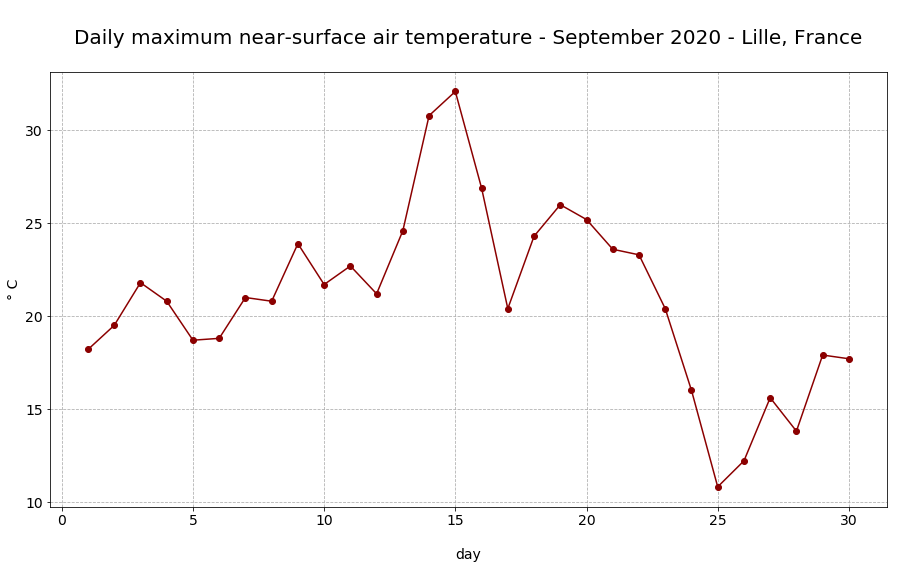

In [53]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

ax.plot(x, y, 'bo-', color='darkred')


ax.set_title('\n'+era5_t2m_max_2020_lille.long_name+'\n', fontsize=20)
ax.set_ylabel(era5_t2m_max_2020_lille.units, fontsize=14)
ax.set_xlabel('\nday', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.grid(linestyle='--')

#for i,j in zip(x,y):
#    ax.annotate(str(j),
#                xy=(i,j), 
#                fontsize=14)


<br>

Above, you see that on 15. September, Lille experienced the highest temperature for September 2020. If you want to select the maximum value of the data array `era5_t2m_max_2020_lille`, you can simply apply the function `max()`. If you additionally add `values` to it, you can extract the data value from the `xarray.DataArray` structure.

You see, that on 15. September 2020, the maximum temperature was 32.1 degrees Celsius.

In [57]:
era5_t2m_max_2020_lille.max().values

array(32.05613, dtype=float32)

<br>

The question that remains open is whether temperatures above 30 degrees Celsius are normal for Lille or whether the 15 September 2020 was an extreme. For this to find out, let us compare the maximum daily temperatures for September 2020 with the long term average of the same region. 

<br>

## <a id='longterm_averages'></a>2. Calculation of the long term average of daily maximum near-surface air temperature over northern France for September


We will now seek to discover just how high the temperature for Lille in mid September 2020 was when compared to typical values exptected in this region at this time of year. To do that we will calculate the mean and standard deviation of maximum daily 2m temperature for each day in September for the period of 1979 to 2019, and compare these with our values for 2020.

First we select all data prior to 2020:

In [11]:
Lille_past = Lille_t2m.loc['1979':'2019']

Now we calculate the climatology for this data, i.e. the mean and standard deviation of maximum daily values for each of the days in September for a period of several decades (from 1979 to 2019).

To do this, we first have to extract the maximum daily value for each day in the time series:

In [12]:
Lille_max = Lille_past.resample(time='D').max()

Then we can calculate the mean and standard deviation of this for the 40 year time series for each day in September:

In [13]:
Lille_m = Lille_max.groupby('time.day').mean('time')
Lille_sd = Lille_max.groupby('time.day').std('time')

Let's plot this data. We will plot the mean plus and minus one standard deviation to have an idea of the expected range of maximum daily temperatures in this part of France in September:

Text(0.5, 1.0, 't2m climatology for Sep from 1979 to 2019')

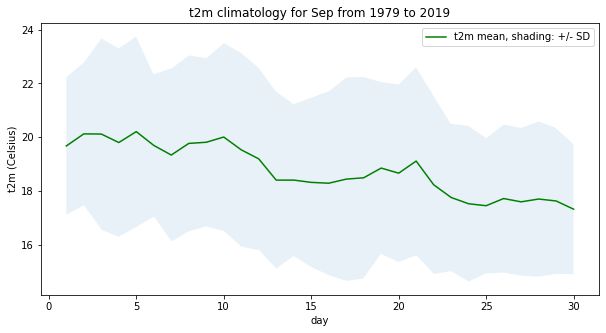

In [14]:
y1 = Lille_m
y2 = Lille_m + Lille_sd
y2 = np.squeeze(y2.values)
y3 = Lille_m - Lille_sd
y3 = np.squeeze(y3.values)

fig = plt.figure(figsize=(10,5))
ax = plt.subplot()
ax.set_ylabel('t2m (Celsius)')
ax.set_xlabel('day')
ax.plot(Lille_m.day, y1, color='green', label='t2m mean, shading: +/- SD')
ax.plot(Lille_m.day, y2, color='white')
ax.plot(Lille_m.day, y3, color='white')
ax.fill_between(Lille_m.day, y2, y3, alpha=0.1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.set_title('t2m climatology for Sep from 1979 to 2019')

What is the typical range of maximum 2m temperature values for September 15?

We will now look more closely at the probability distribution of maximum temperatures for 15 September in this time period. To do this, we will first select only the max daily temperature for 15 September, for each year in the time series:

In [15]:
Lille_max = Lille_max.dropna('time', how='all')
Lille_15 = Lille_max[14::30]

We will then plot the histogram of this:

(array([ 2.,  3., 11.,  6.,  7.,  5.,  1.,  2.,  3.,  1.]),
 array([12.53629112, 13.94420452, 15.35211792, 16.76003132, 18.16794472,
        19.57585812, 20.98377151, 22.39168491, 23.79959831, 25.20751171,
        26.61542511]),
 <a list of 10 Patch objects>)

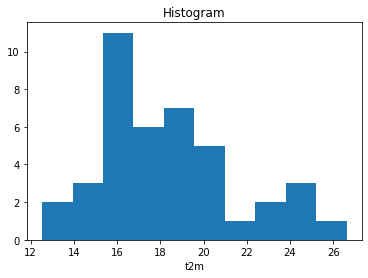

In [16]:
Lille_15.plot.hist()

Look at the range of maximum temperatures for 15 September in the period from 1979 to 2019. Has the temperature in this period ever exceeded that of 15 September 2020?

The histogram shows the distribution of maximum temperature of one day in each year of the time series, which corresponds to 41 samples. In order to increase the number of samples, let's plot the histogram of maximum temperatures on 15 September, plus or minus three days. This would increase our number of samples by a factor of seven.

To do this, we first need to produce an index that takes 15 Sep, plus or minus three days, from every year in the time series:

In [18]:
years = np.arange(41)
days_in_sep = np.arange(11,18)
index = np.zeros(287)
for i in years:
    index[i*7:(i*7)+7] = days_in_sep + (i*30)
index = index.astype(int)

Then we apply this index to filter the array of max daily temperature from 1979 to 2019: 

In [19]:
Lille_7days = Lille_max.values[index]

Now we can plot the histogram of maximum daily temperatures in days 12-18 September from 1979-2019:

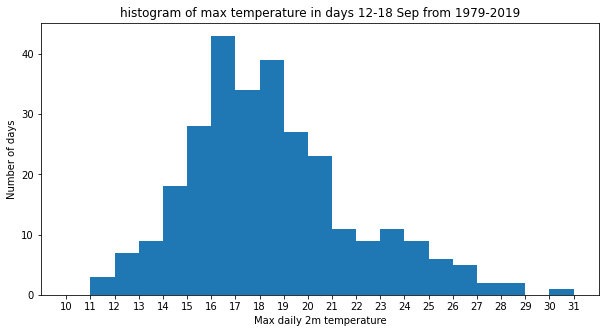

In [24]:
plt.figure(figsize=(10,5))
plt.hist(Lille_7days, bins = np.arange(10,32,1)) 
plt.title("histogram of max temperature in days 12-18 Sep from 1979-2019")
plt.xlabel("Max daily 2m temperature")
plt.ylabel("Number of days")
plt.xticks(np.arange(10,32,1))
plt.show()

Even in this increased temporal range, the maximum daily temperature still never reached that of 15 September 2020!

<hr>